In [1]:
!pip install pandas numpy matplotlib plotly seaborn

In [2]:
import os
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
files_to_read = ['rqc_off_stats.txt', 'rqc_on_stats.txt']

def read_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()
        return lines

def get_rocksdb_compact_write_bytes(lines) -> List[str]:
    return [line for line in lines if 'rocksdb.compact.write.bytes' in line]

def get_rocksdb_flush_write_bytes(lines) -> List[str]:
    return [line for line in lines if 'rocksdb.flush.write.bytes' in line]

def transform_bytes(lines) -> List[int]:
    return [int(line.strip(' \n').split(' : ')[1]) for line in lines]

def get_total_bytes(compact_bytes, flush_bytes) -> List[int]:
    return [compact_bytes[i] + flush_bytes[i] for i in range(len(compact_bytes))]

def get_levels_stats(lines) -> List[Tuple[str, int, int]]:
    return [line.strip(' \t') for line in lines if 'Level-' in line or 'Total:' in line]

def get_total_files_and_entries(lines) -> Tuple[int, int]:
    total_files = 0
    total_entries = 0

    for line in lines:
        if 'Total' in line:
            values = line.strip(' \t').split() 
            total_files = int(values[1])
            total_entries = int(values[2])
            break
    
    return total_files, total_entries

## Space Amplification for different values of UTL and LTU ratios

In [5]:
experiments = os.listdir('./')

results = list()

for experiment in experiments:

    if not os.path.isdir(experiment):
        continue

    i, inserts, u, updates, s, range_queries, y, selectivity, t, size_ratio, *others = experiment.split(' ')
    
    if len(others) == 2:
        rq, rqc = others
        utl, utl_value = None, 0
        ltu, ltu_value = None, 0
    else:
        w, wc, utl, utl_value, ltu, ltu_value, rq, rqc = others

    if rqc =='0':
        approach = 'vanilla'
        lines = read_file(f'{experiment}/rqc_off_stats.txt')
    else:
        approach = 'rqdc'
        lines = read_file(f'{experiment}/rqc_on_stats.txt')

    # files and entries
    sst_file_size_ = read_file(f'{experiment}/sst_file_size_and_count.txt')
    total_files, totat_db_size = sst_file_size_[0].split('\t')
    iperf_total_files, iperf_total_entries = get_total_files_and_entries(lines)

    iperf_total_size = 256 * iperf_total_entries

    # write bytes
    compact_write_bytes = get_rocksdb_compact_write_bytes(lines)
    flush_write_bytes = get_rocksdb_flush_write_bytes(lines)

    compact_bytes = transform_bytes(compact_write_bytes)
    flush_bytes = transform_bytes(flush_write_bytes)


    results.append({
        'inserts': inserts,
        'updates': updates,
        'range_queries': range_queries,
        'size_ratio': size_ratio,
        'rqc': rqc,
        'utl': utl_value,
        'ltu': ltu_value,
        'approach': approach,
        'iperf_total_size': iperf_total_size,
        'iperf_total_files': iperf_total_files,
        'total_files': int(total_files.strip()),
        'total_db_size': int(totat_db_size.strip()),
        'compact_write_bytes': compact_bytes[-1],
        'flush_write_bytes': flush_bytes[-1],
        'total_write_bytes': get_total_bytes(compact_bytes, flush_bytes)[-1],
    })

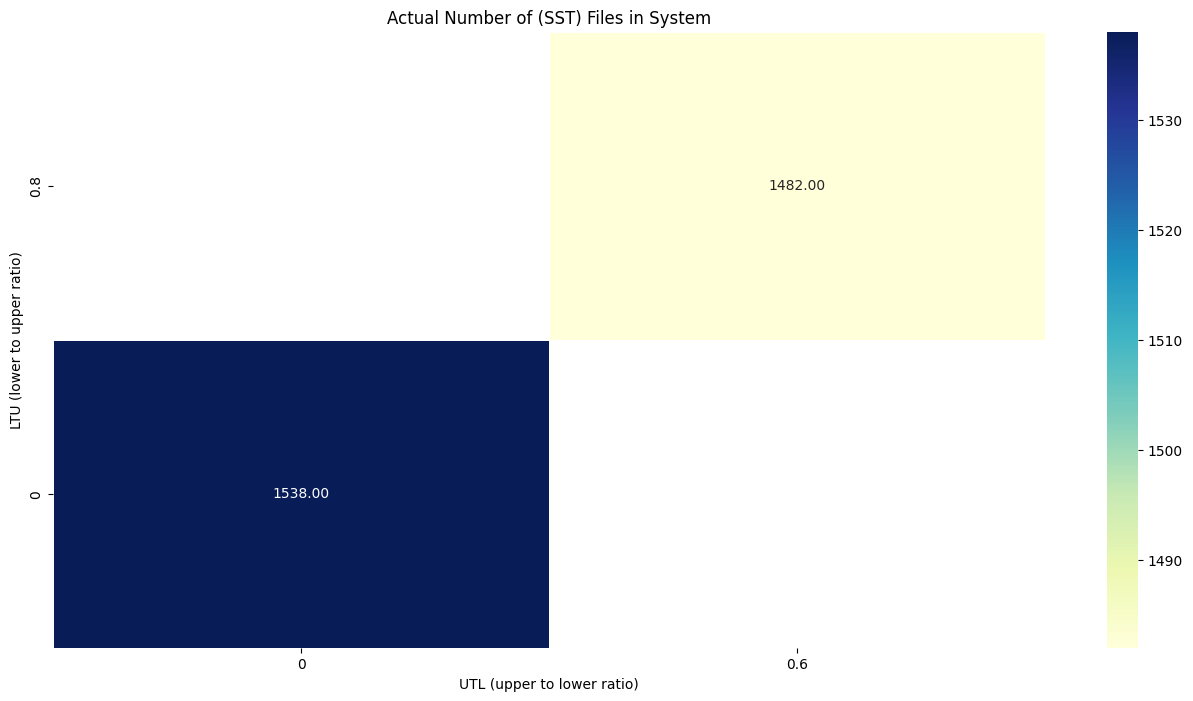

In [6]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'total_files']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='total_files')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Actual Number of (SST) Files in System')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

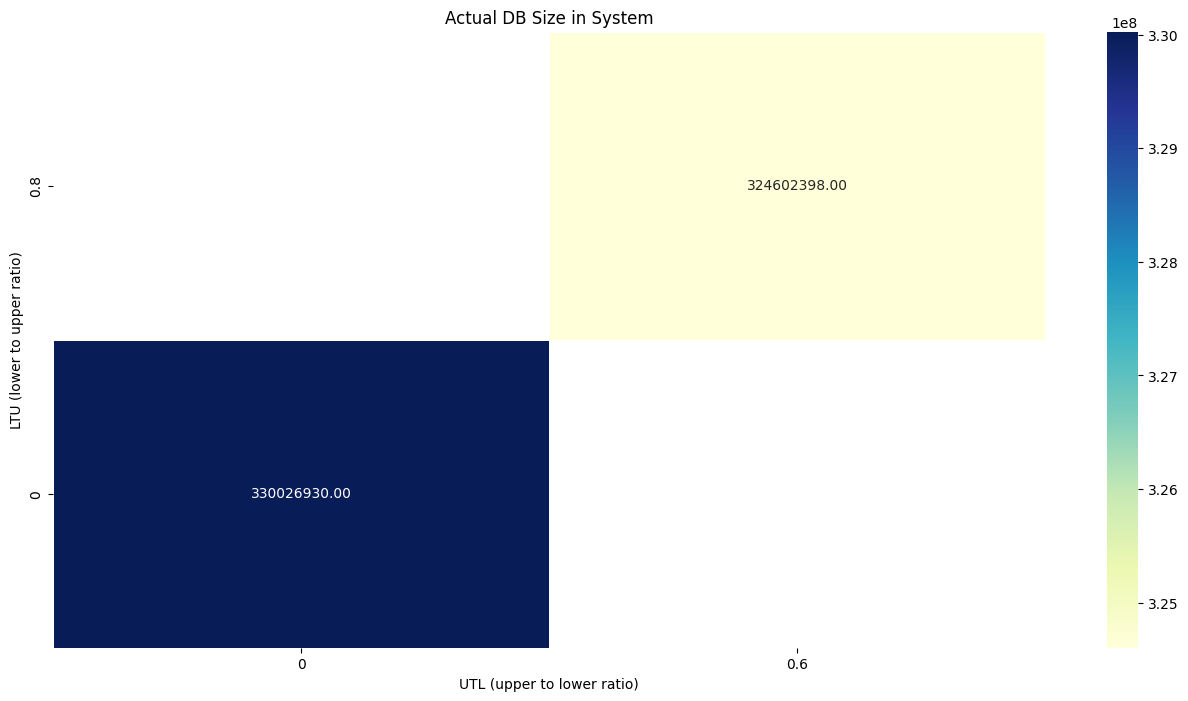

In [7]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'total_db_size']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='total_db_size')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Actual DB Size in System')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

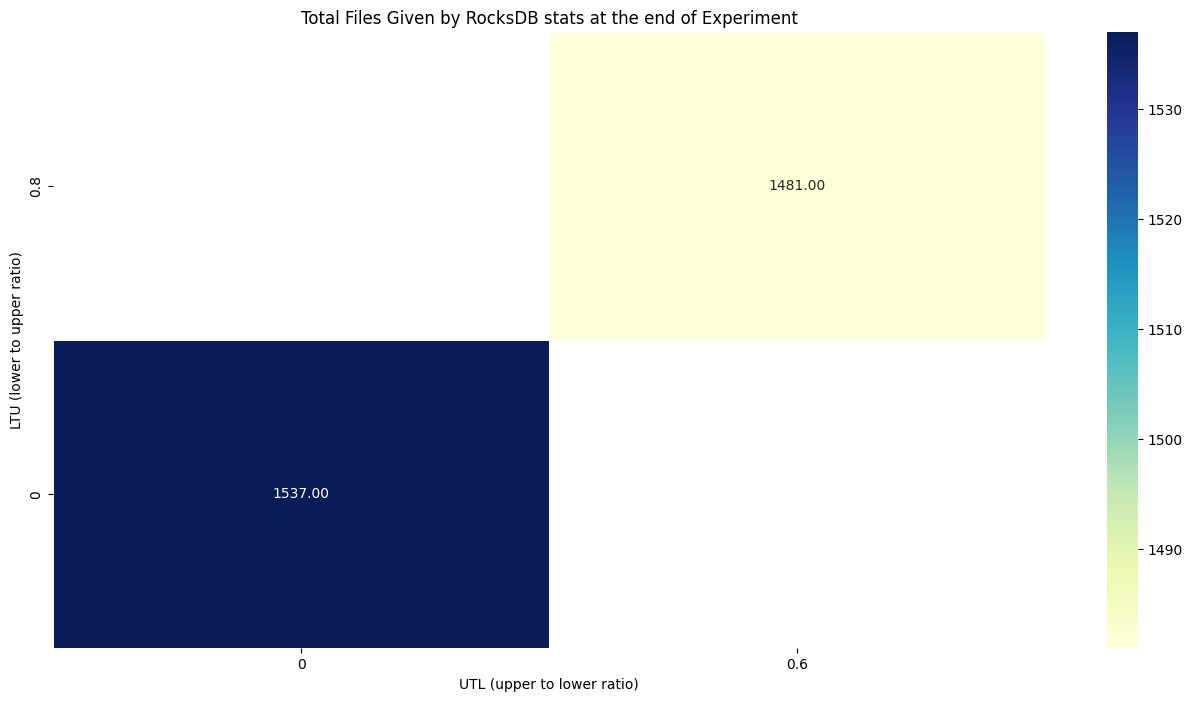

In [8]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'iperf_total_files']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='iperf_total_files')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Files Given by RocksDB stats at the end of Experiment')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

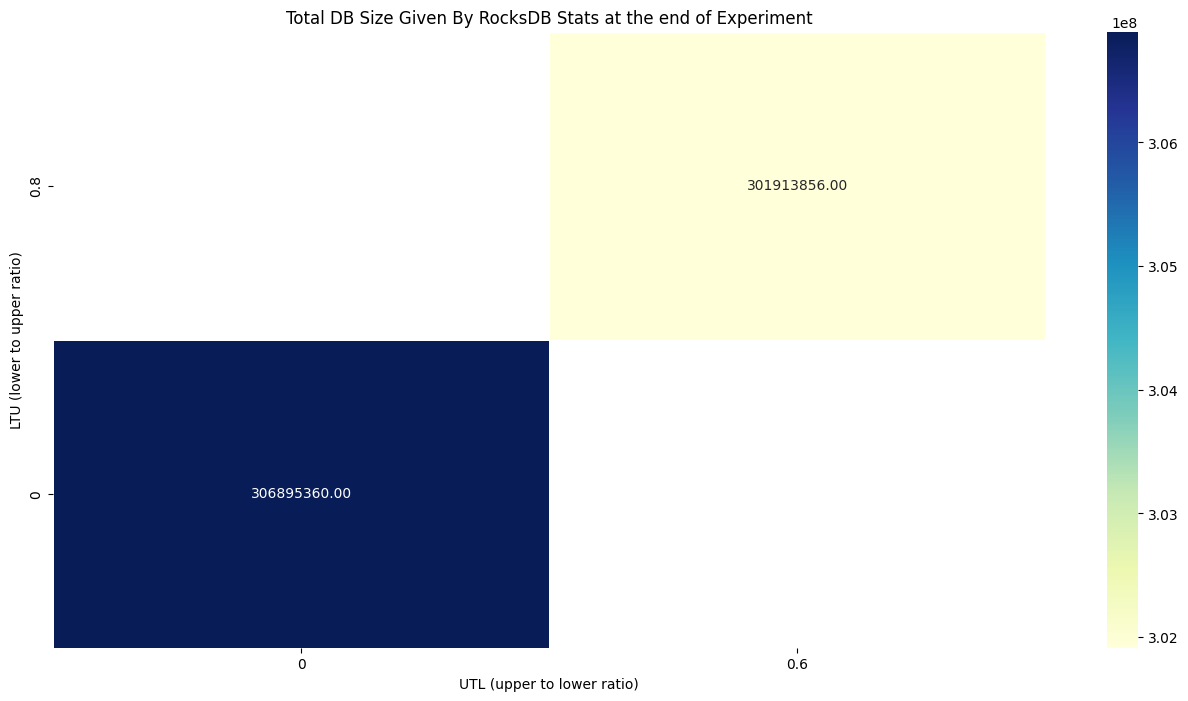

In [9]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'iperf_total_size']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='iperf_total_size')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total DB Size Given By RocksDB Stats at the end of Experiment')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

## Write Amplification for different values of UTL and LTU ratios

In [ ]:
# experiments = os.listdir('./')

# results = list()

# for experiment in experiments:

#     if not os.path.isdir(experiment):
#         continue

#     i, inserts, u, updates, s, range_queries, t, size_ratio, *others = experiment.split(' ')
    
#     if len(others) == 2:
#         rq, rqc = others
#         utl, utl_value = None, 0
#         ltu, ltu_value = None, 0
#     else:
#         utl, utl_value, ltu, ltu_value, rq, rqc = others

#     if rqc =='0':
#         approach = 'vanilla'
#         lines = read_file(f'{experiment}/rqc_off_stats.txt')
#     else:
#         approach = 'rqdc'
#         lines = read_file(f'{experiment}/rqc_on_stats.txt')

#     compact_write_bytes = get_rocksdb_compact_write_bytes(lines)
#     flush_write_bytes = get_rocksdb_flush_write_bytes(lines)

#     compact_bytes = transform_bytes(compact_write_bytes)
#     flush_bytes = transform_bytes(flush_write_bytes)

#     results.append({
#         'inserts': inserts,
#         'updates': updates,
#         'range_queries': range_queries,
#         'size_ratio': size_ratio,
#         'rqc': rqc,
#         'utl': utl_value,
#         'ltu': ltu_value,
#         'approach': approach,
#         'compact_write_bytes': compact_bytes[-1],
#         'flush_write_bytes': flush_bytes[-1],
#         'total_write_bytes': get_total_bytes(compact_bytes, flush_bytes)[-1],
#     })

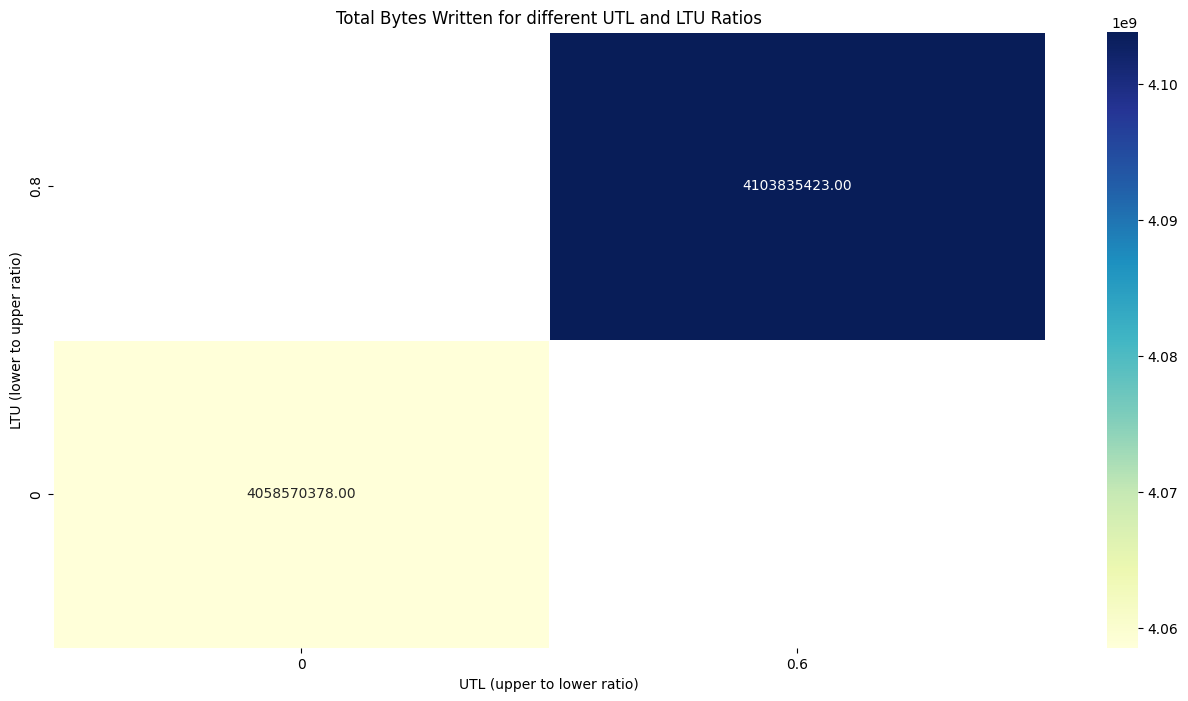

In [10]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'total_write_bytes']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='total_write_bytes')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Bytes Written for different UTL and LTU Ratios')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

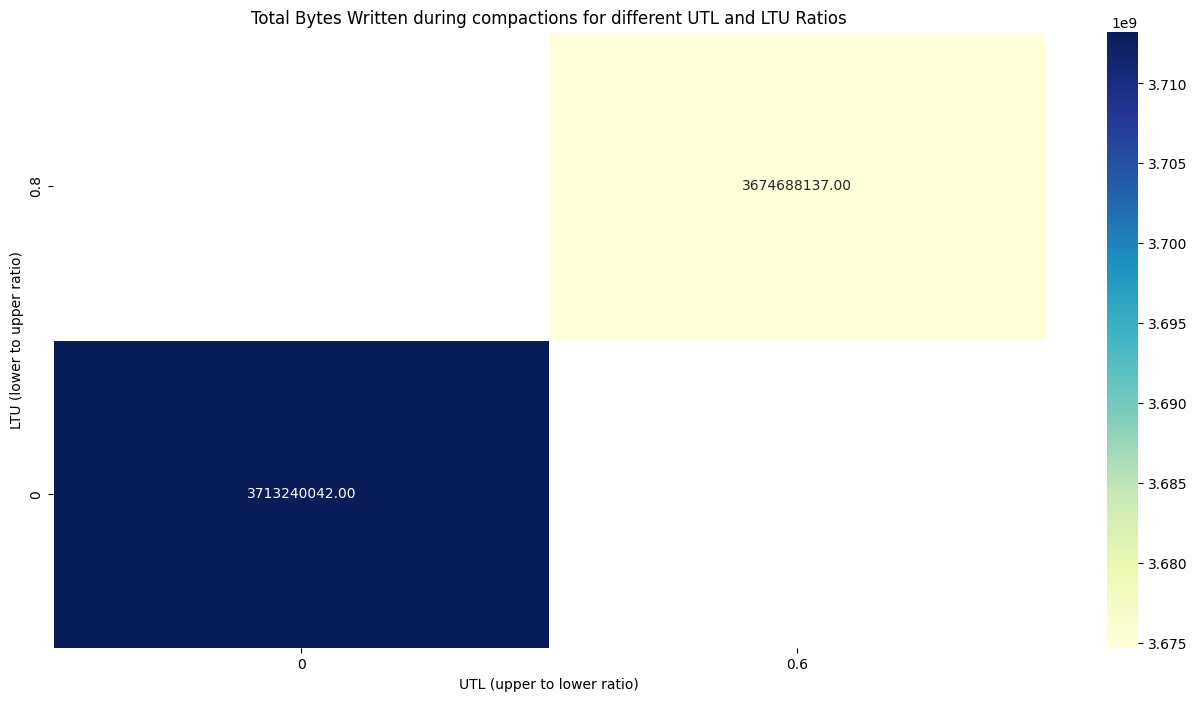

In [11]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'compact_write_bytes']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='compact_write_bytes')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Bytes Written during compactions for different UTL and LTU Ratios')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

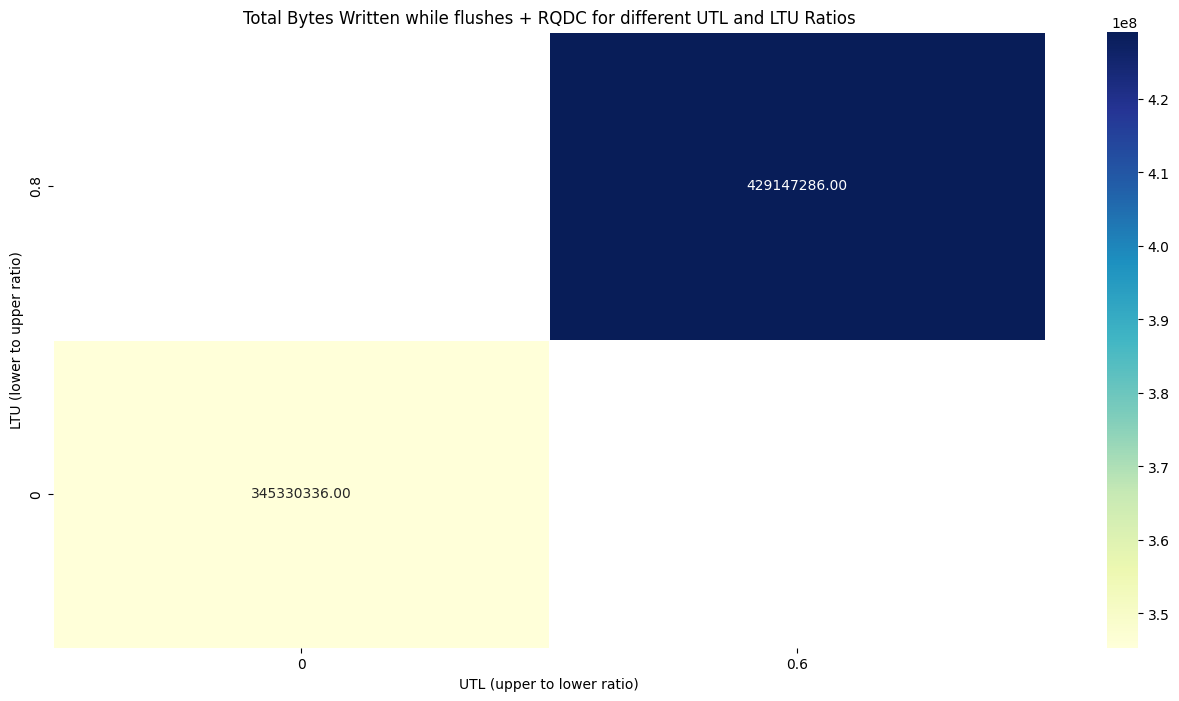

In [12]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'flush_write_bytes']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='flush_write_bytes')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Bytes Written while flushes + RQDC for different UTL and LTU Ratios')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

## Workload Latency for different values of UTL and LTU ratios

In [14]:
experiments = os.listdir('./')

results = list()

for experiment in experiments:

    if not os.path.isdir(experiment):
        continue

    i, inserts, u, updates, s, range_queries, y, selectivity, t, size_ratio, *others = experiment.split(' ')
    
    if len(others) == 2:
        rq, rqc = others
        utl, utl_value = None, 0
        ltu, ltu_value = None, 0
    else:
        w, wc, utl, utl_value, ltu, ltu_value, rq, rqc = others

    if rqc =='0':
        approach = 'vanilla'
        compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_off_compacted_vs_skipped.csv')
        stats = pd.read_csv(f'{experiment}/rqc_off_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])
    else:
        approach = 'rqdc'
        compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_on_compacted_vs_skipped.csv')
        stats = pd.read_csv(f'{experiment}/rqc_on_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])

    stats.drop(columns=['dummy', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter'], inplace=True)
    total_workload_time = stats[stats['Type'] == ' Total']
    total_time_taken = total_workload_time.reset_index()['SuccessFailDecisionForRQDC']

    # take the average of total time taken for range queries
    total_range_time = stats[stats['Type'] == ' Range']
    total_range_time_taken = total_range_time.reset_index()['TotalTimeTaken']
    avg_range_time_taken = np.mean(total_range_time_taken)

    # count the number of time we see on average RQDC is successful
    total_range_time_2 = stats[stats['Type'] == ' Range']
    avg_times_success = total_range_time_2.reset_index()['SuccessFailDecisionForRQDC']
    avg_times_success = np.sum(avg_times_success)

    results.append({
        'inserts': inserts,
        'updates': updates,
        'range_queries': range_queries,
        'size_ratio': size_ratio,
        'rqc': rqc,
        'utl': utl_value,
        'ltu': ltu_value,
        'approach': approach,
        'total_time_taken': total_time_taken[0],
        'average_time_taken_by_range_queries': avg_range_time_taken,
        'avg_time_success': avg_times_success,
    })

/tmp/ipykernel_385450/4240850739.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stats = pd.read_csv(f'{experiment}/rqc_on_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])
/tmp/ipykernel_385450/4240850739.py:22: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stats = pd.read_csv(f'{experiment}/rqc_off_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])


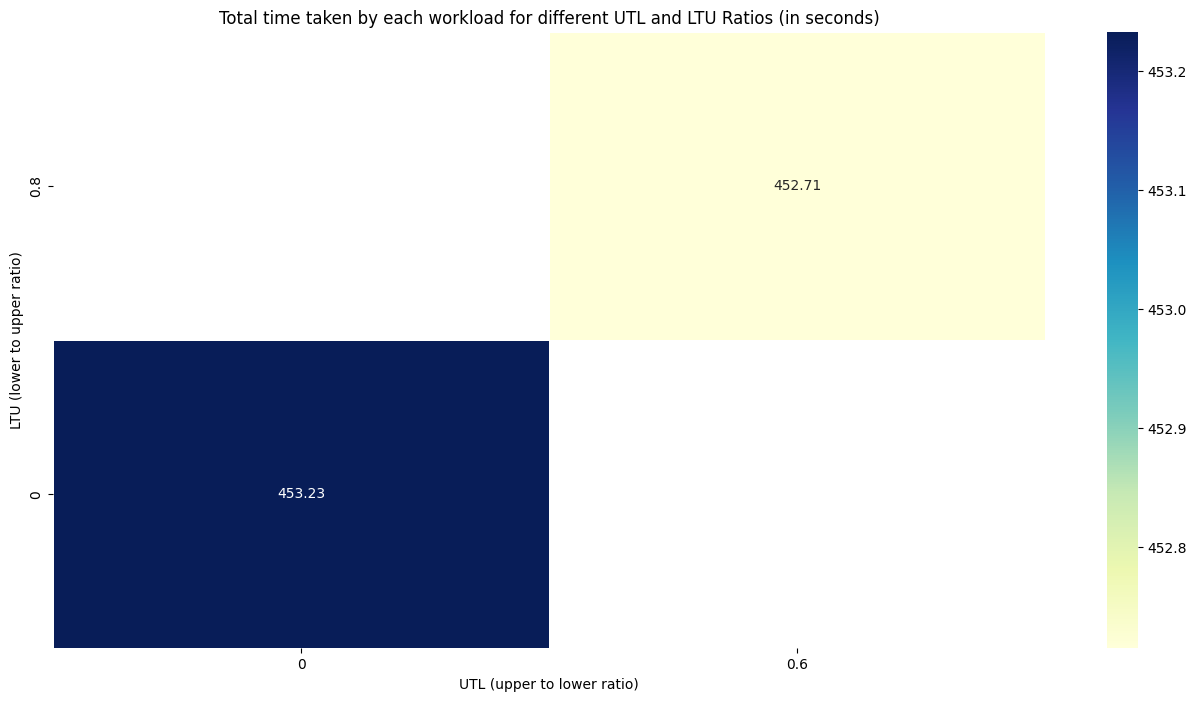

In [15]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'total_time_taken']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='total_time_taken')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Total time taken by each workload for different UTL and LTU Ratios (in seconds)')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

## Average Time taken by range queries for different values of UTL and LTU ratios

In [ ]:
# experiments = os.listdir('./')

# results = list()

# for experiment in experiments:

#     if not os.path.isdir(experiment):
#         continue

#     i, inserts, u, updates, s, range_queries, t, size_ratio, *others = experiment.split(' ')
    
#     if len(others) == 2:
#         rq, rqc = others
#         utl, utl_value = None, 0
#         ltu, ltu_value = None, 0
#     else:
#         utl, utl_value, ltu, ltu_value, rq, rqc = others

#     if rqc =='0':
#         approach = 'vanilla'
#         compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_off_compacted_vs_skipped.csv')
#         stats = pd.read_csv(f'{experiment}/rqc_off_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])
#     else:
#         approach = 'rqdc'
#         compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_on_compacted_vs_skipped.csv')
#         stats = pd.read_csv(f'{experiment}/rqc_on_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])

#     stats.drop(columns=['dummy'], inplace=True)
#     total_workload_time = stats[stats['Type'] == ' Range']
#     total_time_taken = total_workload_time.reset_index()['TotalTimeTaken']

#     # take the average of total time taken for range queries
#     total_time_taken = np.mean(total_time_taken)

#     results.append({
#         'inserts': inserts,
#         'updates': updates,
#         'range_queries': range_queries,
#         'size_ratio': size_ratio,
#         'rqc': rqc,
#         'utl': utl_value,
#         'ltu': ltu_value,
#         'approach': approach,
#         'average_time_taken_by_range_queries': total_time_taken,
#     })

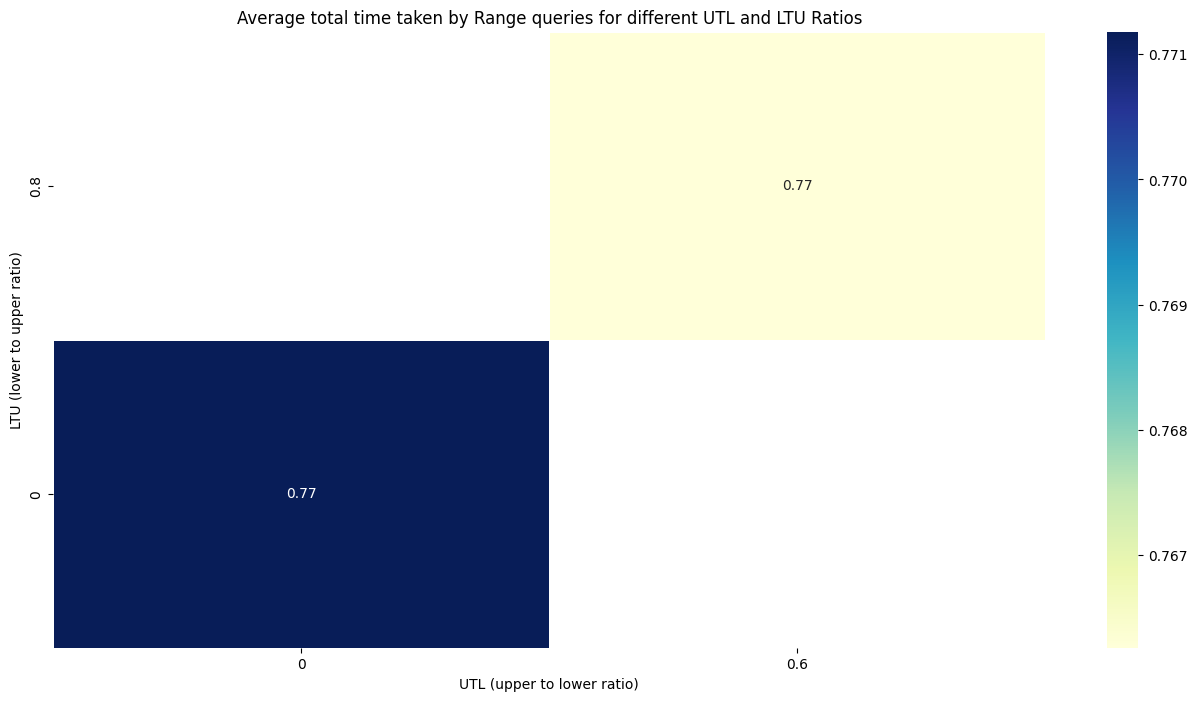

In [16]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'average_time_taken_by_range_queries']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='average_time_taken_by_range_queries')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Average total time taken by Range queries for different UTL and LTU Ratios')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()

## Number of Times the RQDC is Success for different values of UTL and LTU ratios

In [ ]:
# experiments = os.listdir('./')

# results = list()

# for experiment in experiments:

#     if not os.path.isdir(experiment):
#         continue

#     i, inserts, u, updates, s, range_queries, t, size_ratio, *others = experiment.split(' ')
    
#     if len(others) == 2:
#         rq, rqc = others
#         utl, utl_value = None, 0
#         ltu, ltu_value = None, 0
#     else:
#         utl, utl_value, ltu, ltu_value, rq, rqc = others

#     if rqc =='0':
#         approach = 'vanilla'
#         compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_off_compacted_vs_skipped.csv')
#         stats = pd.read_csv(f'{experiment}/rqc_off_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])
#     else:
#         approach = 'rqdc'
#         compacted_vs_skipped = pd.read_csv(f'{experiment}/rqc_on_compacted_vs_skipped.csv')
#         stats = pd.read_csv(f'{experiment}/rqc_on_stats.csv', names=['QueryNo', 'Type', 'Key', 'NumLevelsBefore', 'NumLevelsAfter', 'NumFilesBefore', 'NumFilesAfter', 'NumEntriesBefore', 'NumEntriesAfter', 'TotalTimeTaken', 'SuccessFailDecisionForRQDC', 'dummy'])

#     stats.drop(columns=['dummy'], inplace=True)
#     total_workload_time = stats[stats['Type'] == ' Range']
#     avg_times_success = total_workload_time.reset_index()['SuccessFailDecisionForRQDC']

#     # count the number of time we see on average RQDC is successful
#     avg_times_success = np.sum(avg_times_success)

#     results.append({
#         'inserts': inserts,
#         'updates': updates,
#         'range_queries': range_queries,
#         'size_ratio': size_ratio,
#         'rqc': rqc,
#         'utl': utl_value,
#         'ltu': ltu_value,
#         'approach': approach,
#         'avg_time_success': avg_times_success,
#     })

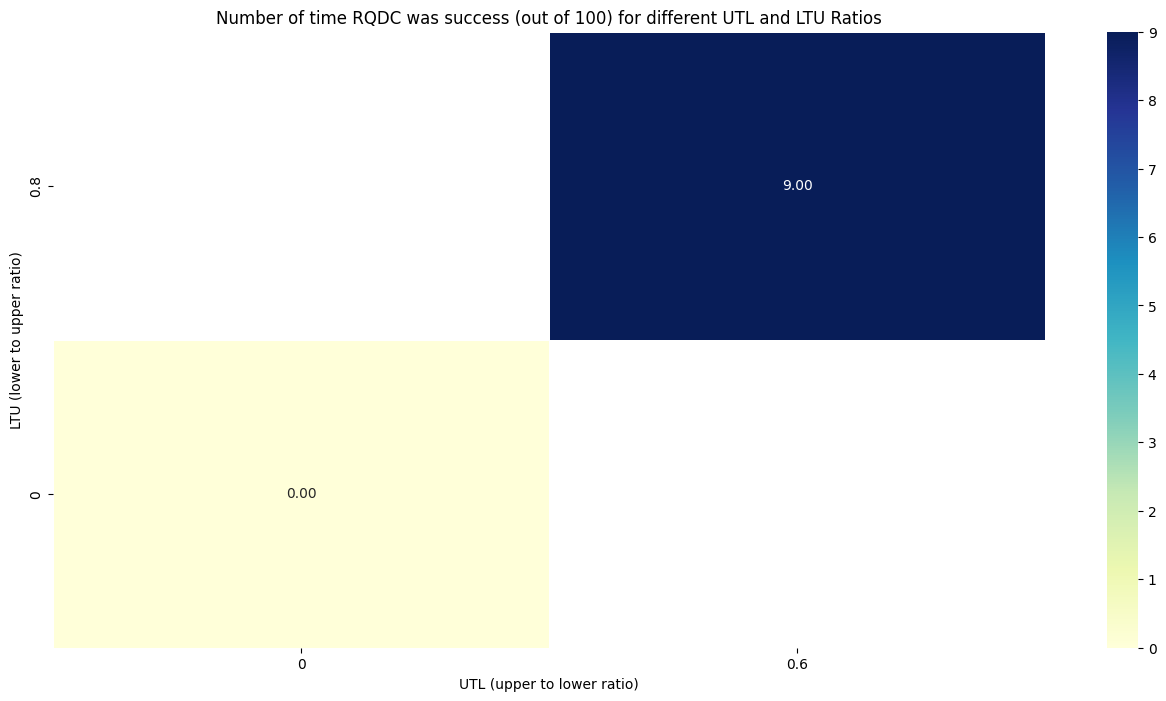

In [17]:
df = pd.DataFrame(results)

df.sort_values(by=['utl', 'ltu'], inplace=True)

number_of_files_df = df[['utl', 'ltu', 'avg_time_success']]

number_of_files_df.head()

heatmap_data = df.pivot_table(index='ltu', columns='utl', values='avg_time_success')

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Number of time RQDC was success (out of 100) for different UTL and LTU Ratios')
plt.xlabel('UTL (upper to lower ratio)')
plt.ylabel('LTU (lower to upper ratio)')
plt.gca().invert_yaxis()
plt.show()